# Merging volumentric ROI measures and freesurfer surface measures.
- Cortical thickness/volume/aseg/wmparc data generated by "../tab_data/freesurfer_stats2table.sh" from fMRIPrep_20.2.0 freesurfer_6.0.1
- Cerebellar segmetations in both SUIT34 and MDTB10 spaces.
- Uses participants data (../tab_data/PPMI_subjects.list ADNI_subjects.list) as target to join, all NaN values droped;
## Cohorts
- PPMI NC, ADNI2 NC
## Parcellations
- Distreux
- DKT
## Results
- Distreux: ../tab_data/ADNI-PPMI_Des-cere_preped.csv
- DKT:      ../tab_data/ADNI-PPMI_DKT-cere_preped.csv

In [1]:
## Preprocessing of ADNI and PPMI dataset freesurfer outputs
#lib and path
from pathlib import Path
import pandas as pd
import seaborn as sns
data_dir = Path("/codes/tab_data")
adni_list_file = data_dir/'ADNI_subjects.list'
ppmi_list_file = data_dir/'PPMI_subjects.list'
# groups
GROUPS   = ['ADNI', 'PPMI']
n_groups = len(GROUPS)
sub_list_file = [data_dir/(x+'_subjects.list') for x in GROUPS]
sub_list = [pd.read_csv(x, sep='\t', header=0, index_col=0) for x in sub_list_file]

# reading freesurfer results
FS_DIR = data_dir/'freesurfer_output_20.2.0'
group_data={};

# output file
res_file = [data_dir/'ADNI-PPMI_Des-cere_preped.csv', data_dir/'ADNI-PPMI_DKT-cere_preped.csv']
combined_res_file = [data_dir/'freesurfer_out_preped.csv']

files_2_read={'seg': ['aseg_stats.txt', 'wmparc_stats.txt'],
              'Destrieux': {'ct': '.a2009s.thickness.txt','area':'.a2009s.area.txt', 'volume':'.a2009s.volume.txt', 'meancurv':'.a2009s.meancurv.txt'},
              'DKT': {'ct': '.DKTatlas.thickness.txt','area':'.DKTatlas.area.txt', 'volume':'.DKTatlas.volume.txt', 'meancurv':'.DKTatlas.meancurv.txt'}}

for i_group in range(n_groups):
    """
    Loop to gather all the freesurfer outputs for ET/PD/NC group.
    Output: all_data (dataframe).
    """
    print('Reading ' , GROUPS[i_group], ' freesurfer stats data...')
    # raw data path
    raw_data_path = FS_DIR/GROUPS[i_group]
    # segmentation
    subcortical_file = raw_data_path / (files_2_read['seg'][0]); wm_file = raw_data_path / 'wmparc_stats.txt'; 
    # Des parcellation
    lh_Des_ct_file = raw_data_path / ('lh'+files_2_read['Destrieux']['ct']);  rh_Des_ct_file = raw_data_path /  ('rh'+files_2_read['Destrieux']['ct']);
    lh_Des_vol_file = raw_data_path / ('lh'+files_2_read['Destrieux']['volume']); rh_Des_vol_file = raw_data_path / ('rh'+files_2_read['Destrieux']['volume']);
    lh_Des_area_file = raw_data_path / ('lh'+files_2_read['Destrieux']['area']); rh_Des_area_file = raw_data_path / ('rh'+files_2_read['Destrieux']['area']);
    lh_Des_meancurv_file = raw_data_path / ('lh'+files_2_read['Destrieux']['meancurv']); rh_Des_meancurv_file = raw_data_path / ('rh'+files_2_read['Destrieux']['meancurv']);
    # DKT parcellation
    lh_DKT_area_file = raw_data_path / ('lh'+files_2_read['DKT']['area']);       rh_DKT_area_file = raw_data_path / ('rh'+files_2_read['DKT']['area']);
    lh_DKT_ct_file = raw_data_path / ('lh'+files_2_read['DKT']['ct']);        rh_DKT_ct_file = raw_data_path /  ('rh'+files_2_read['DKT']['ct']);
    lh_DKT_vol_file = raw_data_path / ('lh'+files_2_read['DKT']['volume']);       rh_DKT_vol_file = raw_data_path / ('rh'+files_2_read['DKT']['volume']);
    lh_DKT_meancurv_file = raw_data_path / ('lh'+files_2_read['DKT']['meancurv']);       rh_DKT_meancurv_file = raw_data_path / ('rh'+files_2_read['DKT']['meancurv']);
    ## drop_list
    aseg_drop = ["EstimatedTotalIntraCranialVol"]; 
    wm_drop = ["MaskVol", "EstimatedTotalIntraCranialVol", "CerebralWhiteMatterVol", "rhCerebralWhiteMatterVol", "lhCerebralWhiteMatterVol"];
    parc_drop = ["BrainSegVolNotVent", "eTIV"]; 
    ##
    subcortical_tab = pd.read_csv(subcortical_file, sep='\t', header=0, index_col=0); 
    subcortical_tab['eTIV']=subcortical_tab['EstimatedTotalIntraCranialVol']
    subcortical_tab.drop(aseg_drop, axis=1, inplace=True);
    res = sub_list[i_group].join(subcortical_tab, how='left');
    wm_tab = pd.read_csv(wm_file, sep='\t', header=0, index_col=0); wm_tab.drop(wm_drop, axis=1, inplace=True);
    res1   = res.join(wm_tab, how='left');
    # read Des/DKT parcelation data
    lh_Des_ct_tab = pd.read_csv(lh_Des_ct_file, sep='\t', header=0, index_col=0); lh_Des_ct_tab.drop(parc_drop, axis=1, inplace=True);
    rh_Des_ct_tab = pd.read_csv(rh_Des_ct_file, sep='\t', header=0, index_col=0); rh_Des_ct_tab.drop(parc_drop, axis=1, inplace=True);
    lh_Des_vol_tab = pd.read_csv(lh_Des_vol_file, sep='\t', header=0, index_col=0); lh_Des_vol_tab.drop(parc_drop, axis=1, inplace=True);
    rh_Des_vol_tab = pd.read_csv(rh_Des_vol_file, sep='\t', header=0, index_col=0); rh_Des_vol_tab.drop(parc_drop, axis=1, inplace=True);
    lh_DKT_ct_tab = pd.read_csv(lh_DKT_ct_file, sep='\t', header=0, index_col=0); lh_DKT_ct_tab.drop(parc_drop, axis=1, inplace=True);
    rh_DKT_ct_tab = pd.read_csv(rh_DKT_ct_file, sep='\t', header=0, index_col=0); rh_DKT_ct_tab.drop(parc_drop, axis=1, inplace=True);
    lh_DKT_vol_tab = pd.read_csv(lh_DKT_vol_file, sep='\t', header=0, index_col=0); lh_DKT_vol_tab.drop(parc_drop, axis=1, inplace=True);
    rh_DKT_vol_tab = pd.read_csv(rh_DKT_vol_file, sep='\t', header=0, index_col=0); rh_DKT_vol_tab.drop(parc_drop, axis=1, inplace=True);
    # merge Des/DKT parcelation data
    seg_Des_tab=res1.join(lh_Des_ct_tab, how='left'); seg_Des_tab=seg_Des_tab.join(rh_Des_ct_tab, how='left'); seg_Des_tab=seg_Des_tab.join(lh_Des_vol_tab,how='left'); seg_Des_tab=seg_Des_tab.join(rh_Des_vol_tab,how='left'); 
    seg_DKT_tab=res1.join(lh_DKT_ct_tab, how='left'); seg_DKT_tab=seg_DKT_tab.join(rh_DKT_ct_tab, how='left'); seg_DKT_tab=seg_DKT_tab.join(lh_DKT_vol_tab,how='left'); seg_DKT_tab=seg_DKT_tab.join(rh_DKT_vol_tab,how='left'); 
    # update group
    seg_Des_tab['group']=GROUPS[i_group]; #seg_Des_tab=seg_Des_tab.dropna();
    seg_DKT_tab['group']=GROUPS[i_group]; #seg_DKT_tab=seg_DKT_tab.dropna();
    # return data
    group_data[GROUPS[i_group]]={'Des': seg_Des_tab, 'DKT':seg_DKT_tab}
all_data = {'Des': pd.concat([group_data['ADNI']['Des'], group_data['PPMI']['Des']]), 'DKT': pd.concat([group_data['ADNI']['DKT'], group_data['PPMI']['DKT']])}
for x in GROUPS:
    print(x , len(group_data[x]['Des']))
for k, v in all_data.items():
    v.index   = [x.replace('-','_') for x in v.index]
    v.columns = [x.replace('-','_') for x in v.columns]

Reading  ADNI  freesurfer stats data...
Reading  PPMI  freesurfer stats data...
ADNI 310
PPMI 117


In [2]:
##Fixing all the format problems: 1. All '-' are replaced by '_'; 
seg_col =[x.replace('-','_') for x in subcortical_tab.columns];
wm_col  =[x.replace('-','_') for x in wm_tab.columns]
lh_des_ct_col=[x.replace('-','_') for x in lh_Des_ct_tab.columns]; rh_des_ct_col=[x.replace('-','_') for x in rh_Des_ct_tab.columns];
lh_dkt_ct_col=[x.replace('-','_') for x in lh_DKT_ct_tab.columns]; rh_dkt_ct_col=[x.replace('-','_') for x in rh_DKT_ct_tab.columns];
lh_des_vol_col=[x.replace('-','_') for x in lh_Des_vol_tab.columns]; rh_des_vol_col=[x.replace('-','_') for x in rh_Des_vol_tab.columns];
lh_dkt_vol_col=[x.replace('-','_') for x in lh_DKT_vol_tab.columns]; rh_dkt_vol_col=[x.replace('-','_') for x in rh_DKT_vol_tab.columns];
import matplotlib.pyplot as plt

In [3]:
## adding cerebellar measures from SUIT software in both SUIT space and MDTB space.
# read SUIT space label
## this part of code need to be updated with the the new SUIT ADNI resutls.
adni_suit_list_file = data_dir/'ADNI_subjects.list'

suit_label_file=data_dir/'atlas'/'Lobules-SUIT.nii.lut'
suit_label_df  =pd.read_csv(suit_label_file, sep=' ', header=None, index_col=None); 
suit_res_files = [data_dir/('res_'+x+'_SUIT34.csv') for x in GROUPS]
suit_res_dfs = [pd.read_csv(x, sep=',', header=None, index_col=None) for x in suit_res_files]
suit_drop_list=[[],[61]]; # cerebellar droplist for ADNI and PPMI

# read MDTB space
MDTB_res_files= [data_dir/('res_'+x+'_MDTB10.csv') for x in GROUPS]
MDTB_res_dfs  = [pd.read_csv(x, sep=',', header=None, index_col=None) for x in MDTB_res_files]
for i_group in range(n_groups):
    #suit_res_dfs[i_group]=suit_res_dfs[i_group].drop(axis=0,index=suit_drop_list[i_group])
    suit_res_dfs[i_group].columns=suit_label_df.iloc[:,7]; 
    suit_res_dfs[i_group].index=[x.replace('-','_') for x in group_data[GROUPS[i_group]]['Des'].index];
    suit_res_dfs[i_group]['suit_total']=suit_res_dfs[i_group].sum(axis=1)
    #MDTB_res_dfs[i_group]=MDTB_res_dfs[i_group].drop(axis=0,index=suit_drop_list[i_group])
    MDTB_res_dfs[i_group].columns=['MDTB_'+str(x+1) for x in range(10)];
    MDTB_res_dfs[i_group].index=[x.replace('-','_') for x in group_data[GROUPS[i_group]]['Des'].index];
    MDTB_res_dfs[i_group]['MDTB_total']=MDTB_res_dfs[i_group].sum(axis=1)
suit_merge=pd.concat(suit_res_dfs); MDTB_merge=pd.concat(MDTB_res_dfs);
cereb_merge=suit_merge.join(MDTB_merge, how='left' );
all_data['Des'] = all_data['Des'].join(cereb_merge, how='left'); all_data['Des']=all_data['Des'].dropna();
all_data['DKT'] = all_data['DKT'].join(cereb_merge, how='left'); all_data['DKT']=all_data['DKT'].dropna();
#for k, v in all_data.items():
#    v.index   = [x.replace('-','_') for x in v.index]
#    v.columns = [x.replace('-','_') for x in v.columns]
suit_col =[x for x in suit_merge.columns];
mdtb_col =[x for x in MDTB_merge.columns];

In [3]:
# display all the variable names 
display(', '.join(seg_col))
display(', '.join(wm_col))
display(', '.join(lh_des_ct_col))
display(', '.join(lh_dkt_ct_col))

'Left-Lateral-Ventricle, Left-Inf-Lat-Vent, Left-Cerebellum-White-Matter, Left-Cerebellum-Cortex, Left-Thalamus-Proper, Left-Caudate, Left-Putamen, Left-Pallidum, 3rd-Ventricle, 4th-Ventricle, Brain-Stem, Left-Hippocampus, Left-Amygdala, CSF, Left-Accumbens-area, Left-VentralDC, Left-vessel, Left-choroid-plexus, Right-Lateral-Ventricle, Right-Inf-Lat-Vent, Right-Cerebellum-White-Matter, Right-Cerebellum-Cortex, Right-Thalamus-Proper, Right-Caudate, Right-Putamen, Right-Pallidum, Right-Hippocampus, Right-Amygdala, Right-Accumbens-area, Right-VentralDC, Right-vessel, Right-choroid-plexus, 5th-Ventricle, WM-hypointensities, Left-WM-hypointensities, Right-WM-hypointensities, non-WM-hypointensities, Left-non-WM-hypointensities, Right-non-WM-hypointensities, Optic-Chiasm, CC_Posterior, CC_Mid_Posterior, CC_Central, CC_Mid_Anterior, CC_Anterior, BrainSegVol, BrainSegVolNotVent, BrainSegVolNotVentSurf, lhCortexVol, rhCortexVol, CortexVol, lhCerebralWhiteMatterVol, rhCerebralWhiteMatterVol, Cer

In [4]:
# save the new freesurfer resutls
res_fs_file = [data_dir/'ADNI-PPMI_Des-fs_preped.csv', data_dir/'ADNI-PPMI_DKT-fs_preped.csv']
all_data['Des'].to_csv(res_fs_file[0])
all_data['DKT'].to_csv(res_fs_file[1])

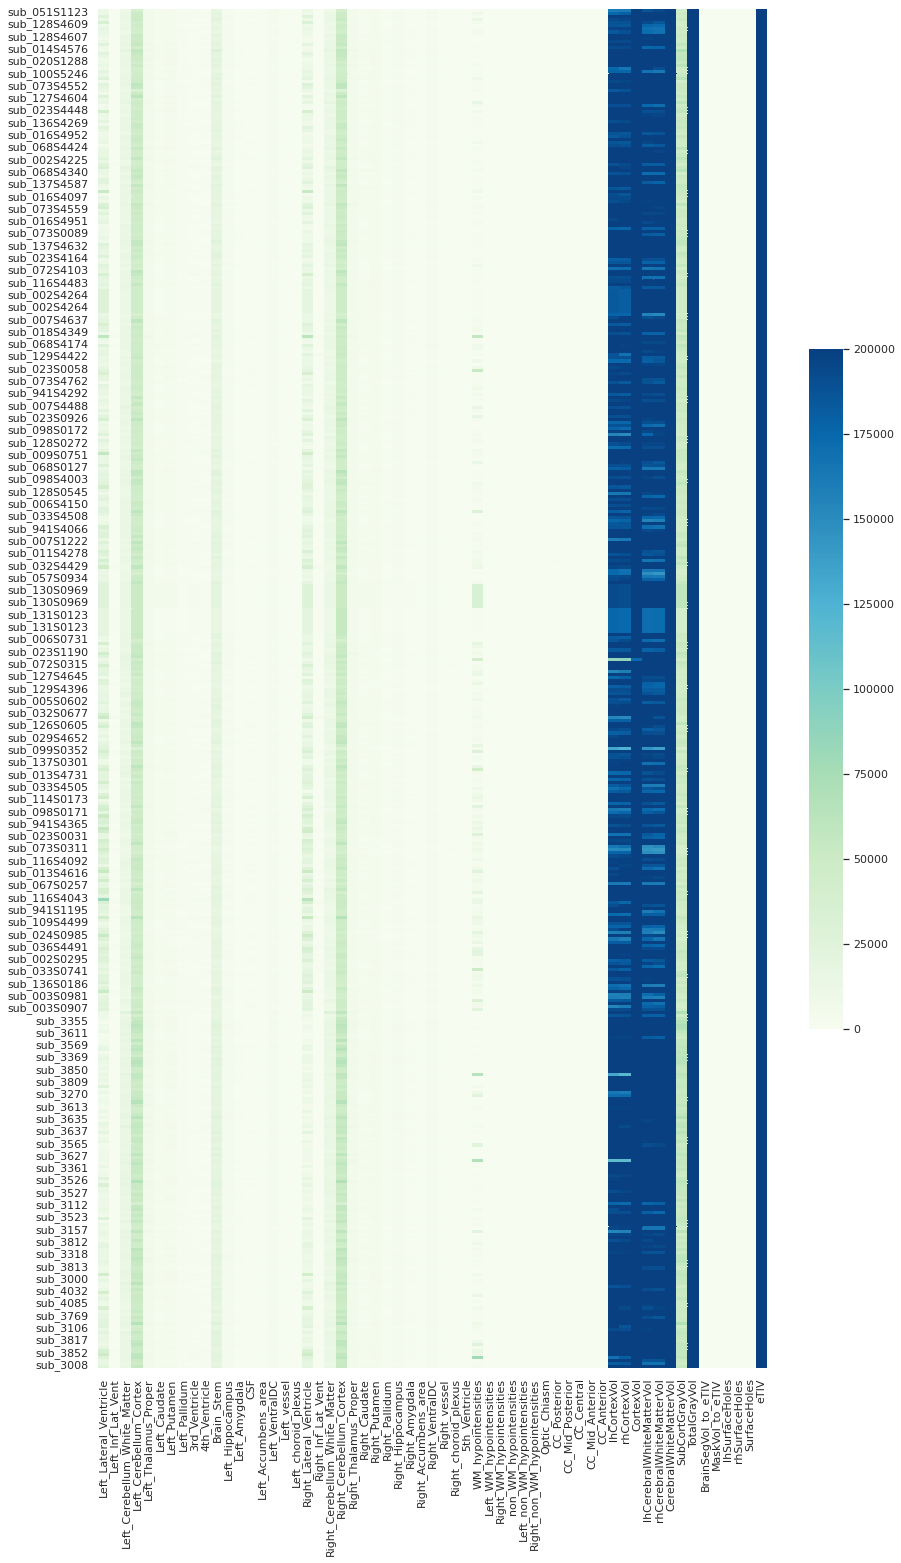

In [5]:
#seg_col-['BrainSegVolNotVent', 'SupraTentorialVolNotVent', 'SupraTentorialVolNotVentVox']
vis_list=seg_col
[ vis_list.remove(x) for x in ['BrainSegVolNotVent', 'SupraTentorialVolNotVent', 'SupraTentorialVolNotVentVox', 'MaskVol','BrainSegVol','BrainSegVolNotVentSurf','SupraTentorialVol'] if x in vis_list ]
plot_df = all_data['Des'].copy()
# sort by age
plot_df = plot_df.sort_values(['group','age'])
plot_df = plot_df[vis_list]
sns.set(font_scale=1)
with sns.axes_style("dark"):
    f, ax = plt.subplots(figsize=(15, 25))
    #sns.color_palette("cubehelix", as_cmap=True)
    g = sns.heatmap(plot_df,cbar_kws={"shrink": .5}, cmap="GnBu",vmin=0, vmax=200000)
    plt.axvline(len(lh_des_ct_col), ls='--',c='white')

In [ ]:
plot_df = all_data['Des'].copy()
# sort by age
plot_df = plot_df.sort_values(['group','age'])
plot_df = plot_df[wm_col]
sns.set(font_scale=1)
with sns.axes_style("dark"):
    f, ax = plt.subplots(figsize=(15, 25))
    #sns.color_palette("cubehelix", as_cmap=True)
    g = sns.heatmap(plot_df,cbar_kws={"shrink": .5}, cmap="GnBu")
    plt.axvline(len(lh_des_ct_col), ls='--',c='white')

In [ ]:
#suit_res_dfs[1].columns
plot_df = all_data['Des'].copy()
# sort by age
plot_df = plot_df.sort_values(['group','age'])
plot_df = plot_df[lh_des_ct_col + rh_des_ct_col ]
sns.set(font_scale=1)
with sns.axes_style("dark"):
    f, ax = plt.subplots(figsize=(15, 25))
    #sns.color_palette("cubehelix", as_cmap=True)
    g = sns.heatmap(plot_df,cbar_kws={"shrink": .5}, cmap="GnBu")
    plt.axvline(len(lh_des_ct_col), ls='--',c='white')

In [ ]:
plot_df = all_data['Des'][lh_des_vol_col + rh_des_vol_col ]
sns.set(font_scale=1)
with sns.axes_style("dark"):
    f, ax = plt.subplots(figsize=(15, 25))
    #sns.color_palette("cubehelix", as_cmap=True)
    g = sns.heatmap(plot_df,cbar_kws={"shrink": .5}, cmap="GnBu")
    plt.axvline(len(lh_des_ct_col), ls='--',c='k')

In [ ]:
plot_df = all_data['DKT'].copy()
vis_list=lh_dkt_ct_col + rh_dkt_ct_col;
# sort by age
plot_df = plot_df.sort_values(['group','age'])
plot_df = plot_df[vis_list]
sns.set(font_scale=1)
with sns.axes_style("dark"):
    f, ax = plt.subplots(figsize=(15, 25))
    #sns.color_palette("cubehelix", as_cmap=True)
    g = sns.heatmap(plot_df,cbar_kws={"shrink": .5}, cmap="GnBu")
    plt.axvline(len(lh_des_ct_col), ls='--',c='white')

In [ ]:
plot_df = all_data['DKT'].copy()
vis_list=lh_dkt_vol_col + rh_dkt_vol_col;
# sort by age
plot_df = plot_df.sort_values(['group','age'])
plot_df = plot_df[vis_list]
sns.set(font_scale=1)
with sns.axes_style("dark"):
    f, ax = plt.subplots(figsize=(15, 25))
    #sns.color_palette("cubehelix", as_cmap=True)
    g = sns.heatmap(plot_df,cbar_kws={"shrink": .5}, cmap="GnBu")
    plt.axvline(len(lh_des_ct_col), ls='--',c='white')

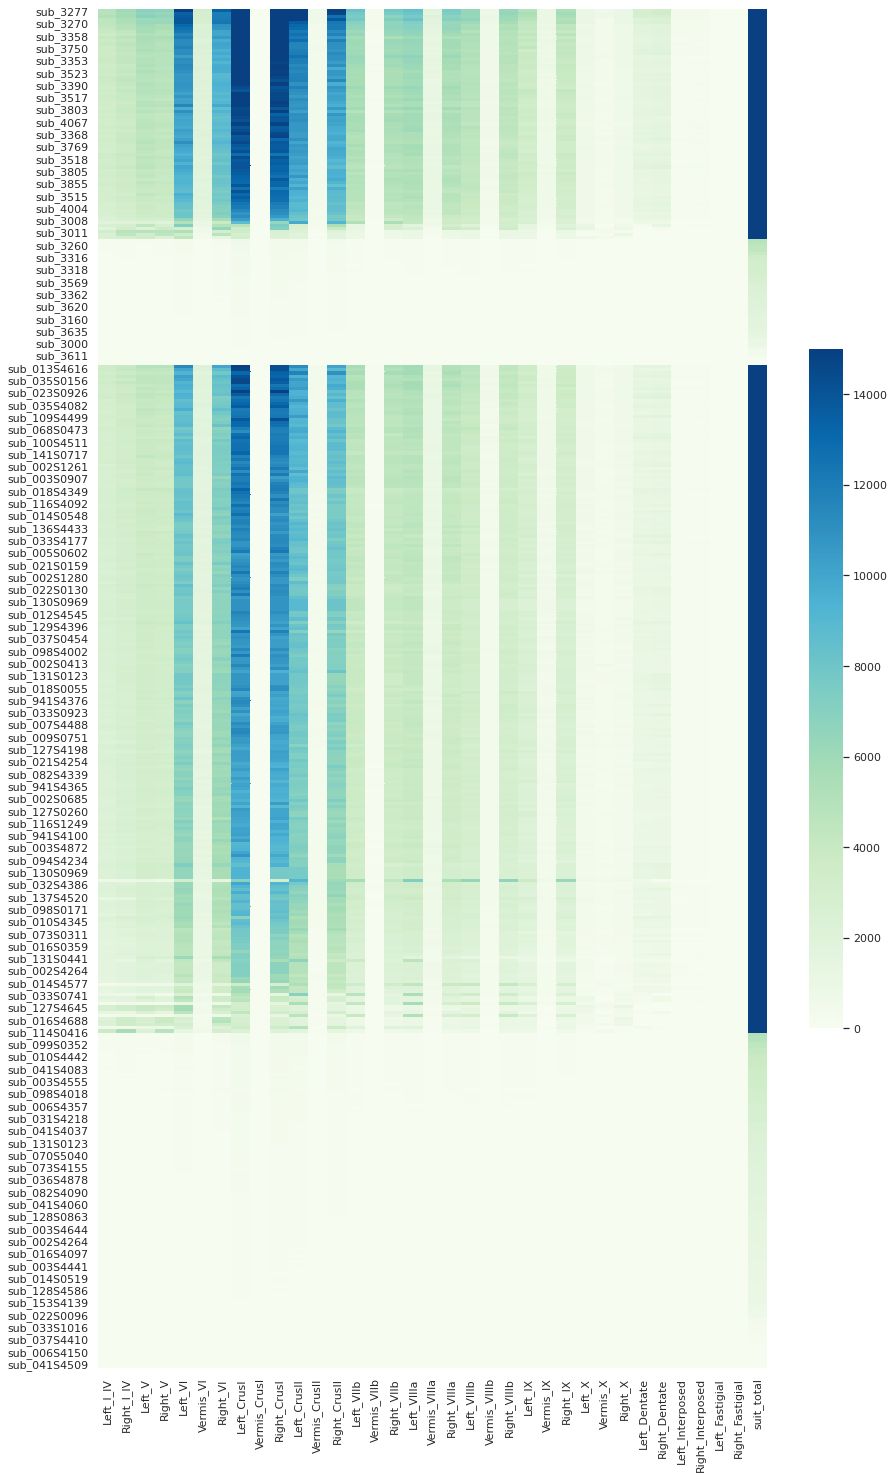

In [19]:
plot_df = all_data['DKT'].copy()
vis_list=suit_col;
# sort by age
plot_df = plot_df.sort_values(['group','suit_total','age'], ascending=False)
plot_df = plot_df[vis_list]
sns.set(font_scale=1)
with sns.axes_style("dark"):
    f, ax = plt.subplots(figsize=(15, 25))
    #sns.color_palette("cubehelix", as_cmap=True)
    g = sns.heatmap(plot_df,cbar_kws={"shrink": .5}, cmap="GnBu", vmin=0, vmax=15000) # , 
    plt.axvline(len(lh_des_ct_col), ls='--',c='white')

In [38]:
plot_df = all_data['DKT'].copy()
plot_df = plot_df[suit_col+['group','age']]
#plot_df[plot_df['Left_I_IV']<1000]['Left_I_IV']
plot_df = plot_df.sort_values(['suit_total','group'], ascending=False)
cere0_df=plot_df[plot_df['Left_I_IV']==0]
cere0_df=cere0_df.sort_values(['group','age'], ascending=False)
display(cere0_df)
display(len(cere0_df.index), ','.join(list(cere0_df.index)))
cere_small_df=plot_df[(plot_df['Left_I_IV']>0) & (plot_df['Left_I_IV']<1000)]
cere_small_df=cere_small_df.sort_values(['group','age'], ascending=False)
display(cere_small_df)
display(len(cere_small_df.index), ','.join(list(cere_small_df.index)))

,Left_I_IV,Right_I_IV,Left_V,Right_V,Left_VI,Vermis_VI,Right_VI,Left_CrusI,Vermis_CrusI,Right_CrusI,...,Right_X,Left_Dentate,Right_Dentate,Left_Interposed,Right_Interposed,Left_Fastigial,Right_Fastigial,suit_total,group,age
sub_3350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PPMI,83
sub_3257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PPMI,53
sub_941S1195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ADNI,86
sub_006S4150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ADNI,78
sub_037S4308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ADNI,76
sub_018S4400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ADNI,75
sub_135S4446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ADNI,72
sub_041S4509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ADNI,69
sub_006S4449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ADNI,68


9

'sub_3350,sub_3257,sub_941S1195,sub_006S4150,sub_037S4308,sub_018S4400,sub_135S4446,sub_041S4509,sub_006S4449'

,Left_I_IV,Right_I_IV,Left_V,Right_V,Left_VI,Vermis_VI,Right_VI,Left_CrusI,Vermis_CrusI,Right_CrusI,...,Right_X,Left_Dentate,Right_Dentate,Left_Interposed,Right_Interposed,Left_Fastigial,Right_Fastigial,suit_total,group,age
sub_3160,52.0,60.0,45.0,51.0,102.0,37.0,93.0,212.0,2.0,180.0,...,15.0,3.0,3.0,0.0,0.0,0.0,1.0,1757.0,PPMI,81
sub_3316,101.0,120.0,102.0,101.0,211.0,77.0,193.0,452.0,0.0,357.0,...,25.0,6.0,6.0,0.0,0.0,0.0,0.0,3585.0,PPMI,76
sub_3389,85.0,106.0,79.0,93.0,190.0,59.0,164.0,397.0,2.0,307.0,...,26.0,5.0,5.0,1.0,0.0,0.0,0.0,3109.0,PPMI,72
sub_3351,55.0,59.0,57.0,55.0,121.0,41.0,96.0,245.0,1.0,199.0,...,14.0,3.0,3.0,0.0,0.0,0.0,0.0,1946.0,PPMI,72
sub_3188,29.0,33.0,28.0,27.0,60.0,23.0,48.0,122.0,0.0,101.0,...,6.0,1.0,1.0,0.0,1.0,0.0,0.0,991.0,PPMI,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub_153S4139,24.0,30.0,30.0,28.0,62.0,20.0,50.0,117.0,0.0,96.0,...,5.0,2.0,3.0,0.0,0.0,0.0,0.0,948.0,ADNI,52
sub_128S4609,65.0,77.0,61.0,68.0,135.0,55.0,116.0,284.0,0.0,225.0,...,18.0,2.0,5.0,0.0,0.0,0.0,0.0,2253.0,ADNI,32
sub_014S0520,32.0,42.0,41.0,35.0,77.0,29.0,62.0,162.0,1.0,135.0,...,10.0,2.0,2.0,0.0,0.0,0.0,1.0,1283.0,ADNI,32
sub_014S0519,36.0,40.0,30.0,36.0,76.0,20.0,65.0,154.0,0.0,121.0,...,10.0,1.0,1.0,1.0,1.0,0.0,0.0,1217.0,ADNI,32


147

'sub_3160,sub_3316,sub_3389,sub_3351,sub_3188,sub_3172,sub_3156,sub_4032,sub_3620,sub_3000,sub_3615,sub_3318,sub_3756,sub_3029,sub_3310,sub_3157,sub_4018,sub_3260,sub_3171,sub_3115,sub_3624,sub_3165,sub_3610,sub_3627,sub_3151,sub_3169,sub_3637,sub_3301,sub_3635,sub_3276,sub_3600,sub_3571,sub_3369,sub_3357,sub_3569,sub_3362,sub_3611,sub_3370,sub_3355,sub_037S0303,sub_003S0981,sub_033S0741,sub_037S0467,sub_041S4060,sub_033S1016,sub_013S4579,sub_098S0896,sub_067S0257,sub_029S4279,sub_041S4083,sub_011S4120,sub_116S0382,sub_022S0096,sub_024S4158,sub_128S0863,sub_031S4218,sub_019S4835,sub_068S0210,sub_099S0352,sub_031S0618,sub_137S4482,sub_027S0120,sub_941S1202,sub_116S1232,sub_098S4018,sub_041S4037,sub_011S0021,sub_141S0767,sub_072S0315,sub_023S1190,sub_128S4586,sub_131S0123,sub_131S0123,sub_131S0123,sub_131S0123,sub_073S4155,sub_014S4080,sub_067S0059,sub_067S0056,sub_032S0479,sub_031S4496,sub_082S4224,sub_128S1242,sub_006S4357,sub_128S0545,sub_021S4421,sub_006S4485,sub_073S4393,sub_011S407

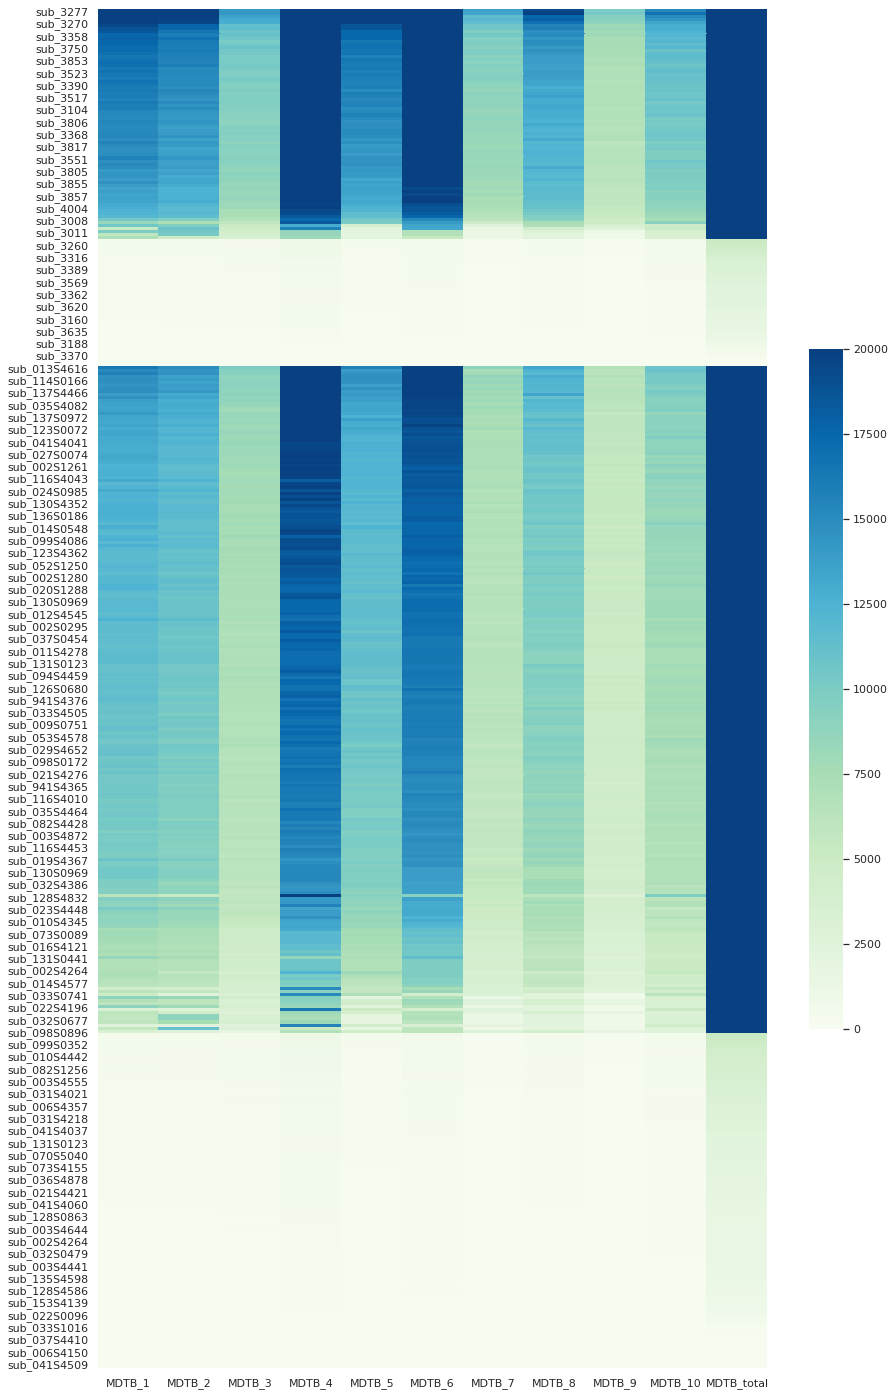

In [20]:
plot_df = all_data['DKT'].copy()
vis_list=mdtb_col;
# sort by age
plot_df = plot_df.sort_values(['group','MDTB_total','age'], ascending=False)
plot_df = plot_df[vis_list]
sns.set(font_scale=1)
with sns.axes_style("dark"):
    f, ax = plt.subplots(figsize=(15, 25))
    #sns.color_palette("cubehelix", as_cmap=True)
    g = sns.heatmap(plot_df,cbar_kws={"shrink": .5}, cmap="GnBu", vmin=0, vmax=20000)
    plt.axvline(len(lh_des_ct_col), ls='--',c='white')

In [ ]:
# visualzie check for PPMI and ADNI
visdf=suit_res_dfs[0].copy()
visdf['participant']=visdf.index
import seaborn as sns
sns.set_theme(style="whitegrid")
# Make the PairGrid
g = sns.PairGrid(visdf.sort_values("suit_total", ascending=False),
                 x_vars=visdf.columns[:10], y_vars=['participant'], height=10, aspect=.2)
# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=5, orient="h", jitter=False, palette="flare_r", linewidth=0.8, edgecolor="w")
# Use the same x axis limits on all columns and add better labels
g.set(xlabel="SUIT PPMI", ylabel="subjects")
# Use semantically meaningful titles for the columns
titles = visdf.columns[:10]
for ax, title in zip(g.axes.flat, titles):
    # Set a different title for each axes
    ax.set(title=title)
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
sns.despine(left=True, bottom=True)

In [ ]:
print(visdf[visdf['Left_I_IV']<1000].index)

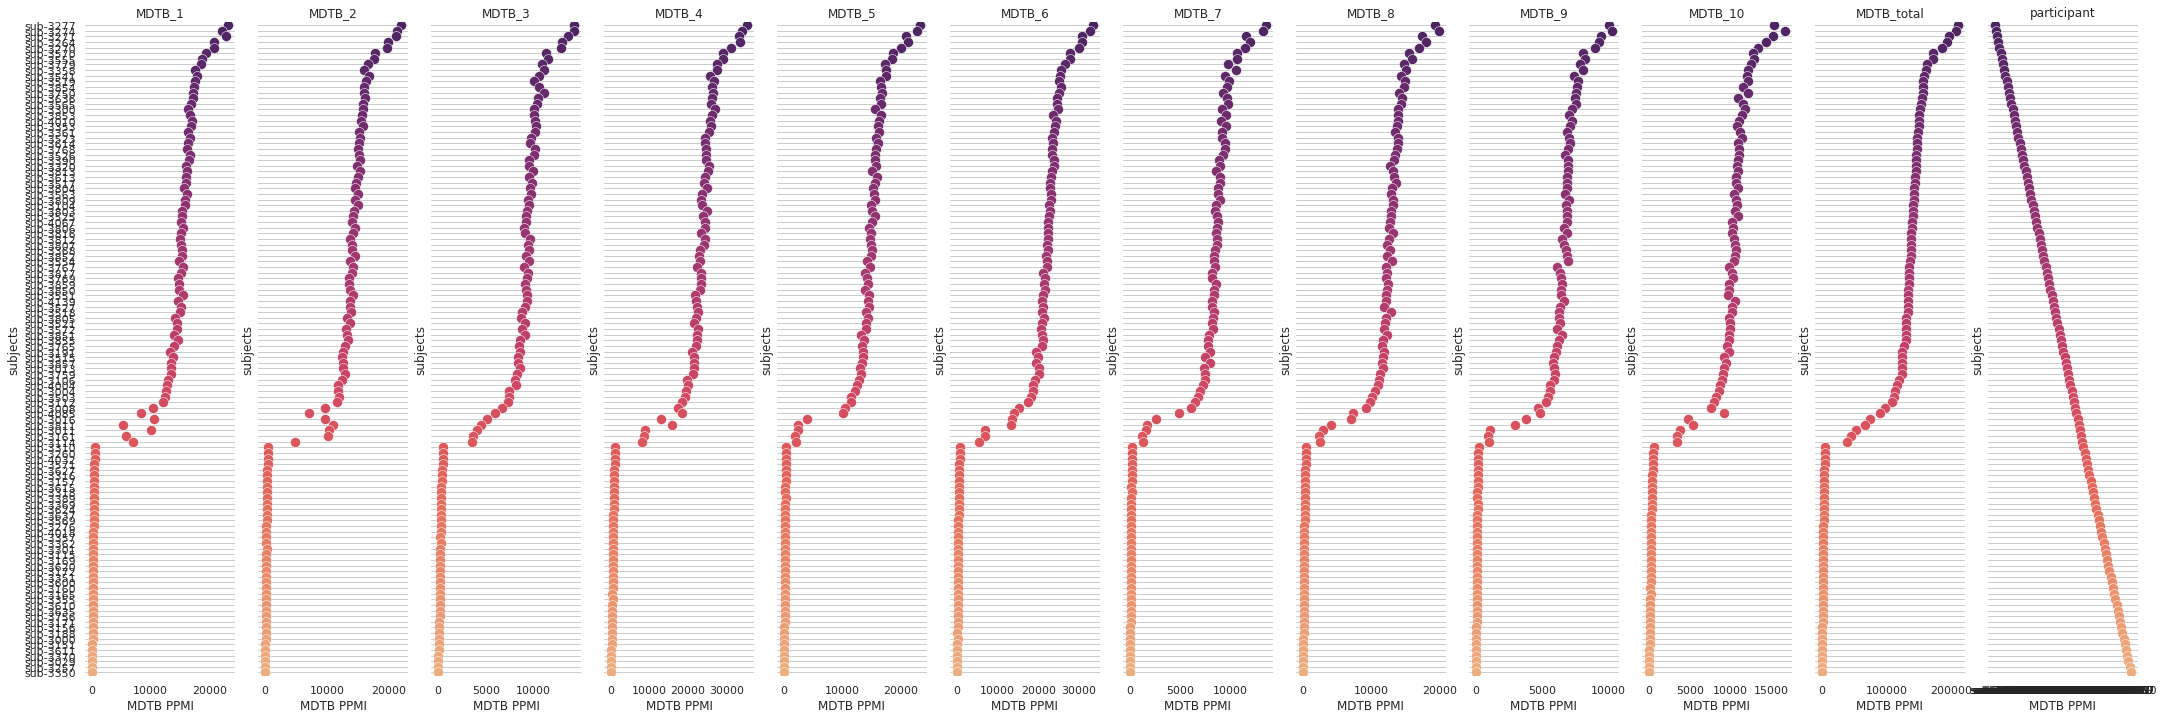

In [41]:
# visualzie check for PPMI and ADNI
visdf=MDTB_res_dfs[1].copy()
visdf['participant']=visdf.index
import seaborn as sns
sns.set_theme(style="whitegrid")
# Make the PairGrid
g = sns.PairGrid(visdf.sort_values("MDTB_total", ascending=False),
                 x_vars=visdf.columns, y_vars=['participant'], height=10, aspect=.25)
# Draw a dot plot using the stripplot function
g.map(sns.stripplot,size=10, orient="h", jitter=False, palette="flare_r", linewidth=0.5, edgecolor="w")
# Use the same x axis limits on all columns and add better labels
g.set(xlabel="MDTB PPMI", ylabel="subjects")
# Use semantically meaningful titles for the columns
titles = visdf.columns
for ax, title in zip(g.axes.flat, titles):
    # Set a different title for each axes
    ax.set(title=title)
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
sns.despine(left=True, bottom=True)

Index(['age', 'sex', 'group', 'Left-Lateral-Ventricle', 'Left-Inf-Lat-Vent',
       'Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex',
       'Left-Thalamus-Proper', 'Left-Caudate', 'Left-Putamen',
       ...
       'MDTB_2', 'MDTB_3', 'MDTB_4', 'MDTB_5', 'MDTB_6', 'MDTB_7', 'MDTB_8',
       'MDTB_9', 'MDTB_10', 'MDTB_total'],
      dtype='object', length=482)

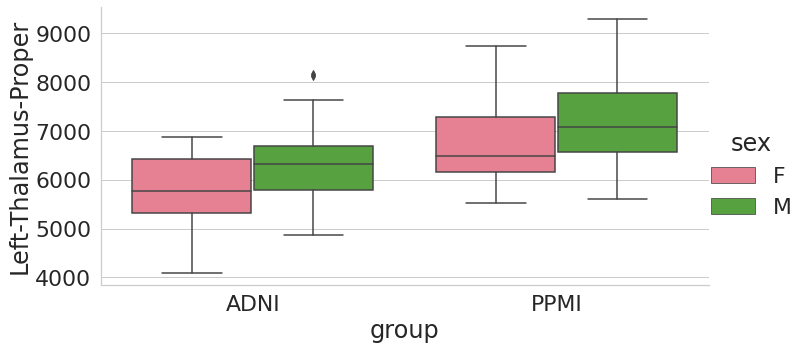

In [15]:
des_vis=all_data['Des'].copy()
display(des_vis.columns)
sns.set(font_scale=2)
palette = sns.color_palette('husl',3)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='Left-Thalamus-Proper', x='group', hue='sex', kind='box',aspect=2, height=5, palette = palette,
                    data=des_vis)
#    if normalize:
#        plt.ylabel('Volume (TBV %)')

In [26]:
#remove problematic subjects
#all_data=all_data.drop(index='sub_0073'); # only left brain NC
#all_data=all_data.drop(index='sub_0064'); # super large head normal control, NC
#all_data.columns

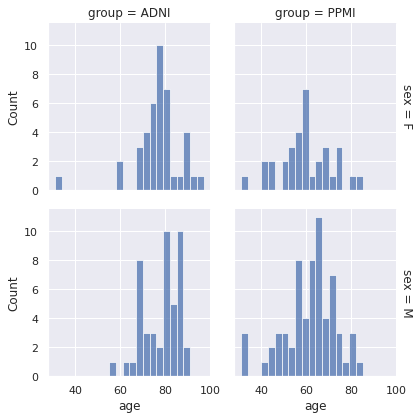

In [4]:
#plot age/sex/diagnosis distributions 2*3
sns.set_theme(style="darkgrid")
sns.displot(
    all_data['Des'], x="age", col="group", row="sex", 
    binwidth=3, height=3, facet_kws=dict(margin_titles=True))

In [5]:
#save data
all_data['Des'].to_csv(res_file[0])
all_data['DKT'].to_csv(res_file[1])

In [19]:
# get data lists
from pathlib import Path
import os
import nipype.interfaces.spm.preprocess as preproc
import nipype.interfaces.spm.utils as spmu

os.chdir(r'/scratch/output/test_suit/PPMI_SUIT_res')
applymat = spmu.ApplyTransform()
applymat.inputs.in_file = 'sub-3000_run-1_desc-preproc_T1w.nii'
applymat.inputs.mat =  'Affine_sub-3000_run-1_desc-preproc_T1w_seg1.mat'
applymat.run()

OSError: No command "matlab" found on host e82ce52bfb8e. Please check that the corresponding package is installed.

In [9]:
data_dir.

'C:\\Users\\Vincent\\Desktop\\scratch\\output\\test_suit\\PPMI_SUIT_res'

In [ ]:
applydef = preproc.ApplyDeformations()
applydef.inputs.in_files = 'functional.nii'
applydef.inputs.deformation_field  = 'func_to_struct.mat'
applydef.inputs.reference_volume   = 'func_to_struct.mat'
applydef.run() 
